In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import gpytorch 

from omegaconf import OmegaConf

In [2]:
from conditional_neural_processes.dataset import GPCurvesReader
from conditional_neural_processes.model import DeterministicEncoder, DeterministicDecoder, DeterministicCNP
from conditional_neural_processes import train

In [3]:
%reload_ext autoreload
%autoreload 2

In [17]:
with open("./conditional_neural_processes/config/config.yaml") as file:
        cfg = OmegaConf.load(file)

encoder_num_layers = cfg.encoder.num_layers
encoder_num_units = cfg.encoder.num_units
encoder_activation_cls = cfg.encoder.activation_cls
decoder_num_layers = cfg.decoder.num_layers
decoder_num_units = cfg.decoder.num_units
decoder_activation_cls = cfg.decoder.activation_cls

r_dim = cfg.r_dim
y_size = cfg.dataset.y_size
x_size = cfg.dataset.x_size
max_num_context = cfg.dataset.max_num_context
batch_size = cfg.dataset.batch_size

lr = cfg.lr
decay_rate = cfg.decay_rate
num_epochs = cfg.num_epochs

## 1D Regression Dataset
$k(X, X') = \sigma^2 \exp (
\frac{-(X-X')^2}{2l}
) + \sigma^2_{noise}$

In [18]:
data_train = GPCurvesReader(batch_size=batch_size, max_num_context=max_num_context)

data_test = GPCurvesReader(batch_size=batch_size, max_num_context=max_num_context, testing=True)

# Conditional Neural Processes (CNP)
## Reference
[The Neural Processes Family - GitHub](https://github.com/google-deepmind/neural-processes/tree/master)
## The CNP model 
- An **encoder** $h$ from input space into representation space that takes in *pairs* of $(x, y)$, context values and produces a representation $r_i = h((x, y)_i)$ for each of the pairs. $h$ is parameterised as a neural network. 
- An **aggregator** $a$ that summarises the encoded inputs. A single order-invariant global representation $r$ is obtained, and the simplest operation that ensures order-invariance and works well in practice is the mean function $r=a(r_i) = \frac{1}{n}\sum_{i=1}^n r_i$. 
- A **decoder** $g$ that takes as input the global representation $r$ as well as the new target locations $x_T$ and outputs embedding $\phi_T$ that parameterises the output distribution. 
    - For regression tasks, $\Phi_i$ parameterises the mean and variance $\phi_i(\mu_i, \sigma_i^2)$  of a Gaussian distribution $\mathcal{N}(\mu_i, \sigma_i^2)$ for every $x_i \in T$. 
   

In [37]:
deterministic_cnp = DeterministicCNP(encoder_num_layers=encoder_num_layers, encoder_num_units=encoder_num_units, encoder_activation_cls=encoder_activation_cls, 
                                     decoder_num_layers=decoder_num_layers, decoder_num_units=decoder_num_units, decoder_activation_cls=decoder_activation_cls,
                                     r_dim=r_dim, y_size=y_size, x_size=x_size
                                    )

Training:   0%|          | 0/200000 [00:00<?, ?it/s]

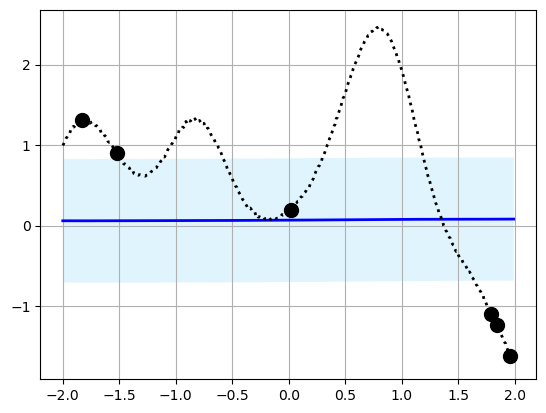

Training:   0%|          | 983/200000 [00:03<09:24, 352.72it/s]

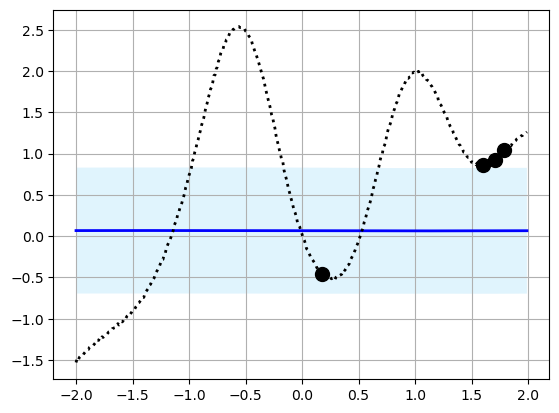

Training:   1%|          | 1977/200000 [00:06<09:13, 357.91it/s]

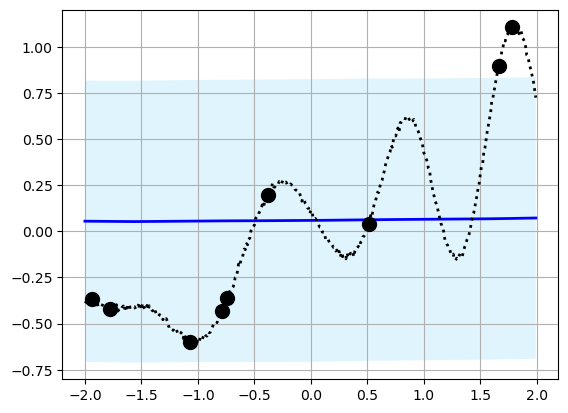

Training:   1%|▏         | 2992/200000 [00:09<09:13, 355.61it/s]

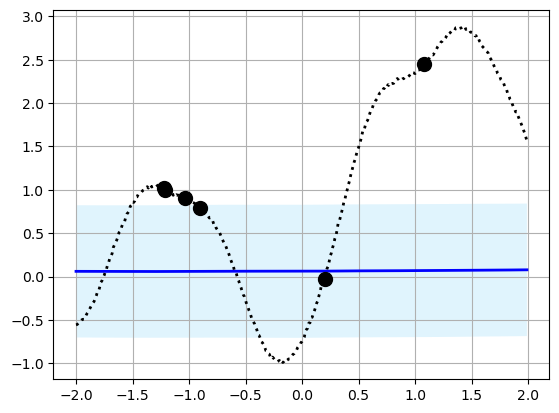

Training:   2%|▏         | 3978/200000 [00:12<09:09, 356.89it/s]

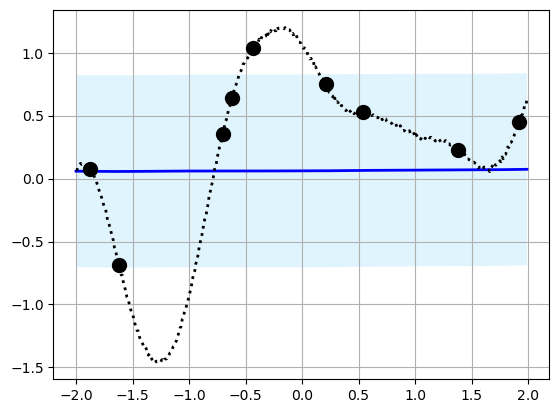

Training:   2%|▏         | 4345/200000 [00:14<10:50, 300.98it/s]


KeyboardInterrupt: 

In [38]:
deterministic_cnp = train(deterministic_cnp, data_train=data_train, data_test=data_test, num_epochs=num_epochs, lr=lr, decay_rate=decay_rate)

# Neural Processes (NP)

In [ ]:
class GobalLatentVariable: 
    def __init__(): 
        super().__init__()
        self.rep_dim = rep_dim
        self.latent_dim = latent_dim 
        activation_func_dict = {'relu': F.relu, 'gelu': F.gelu, 'elu': F.elu}
        self.activation_cls = activation_cls
        self.activation_func = activation_func_dict[activation_cls]
        
        self.hidden_sizes = [rep_dim, num_units for _ in range(num_layers), latent_dim*2]
        self.nn = torch.nn.ModuleList(
            torch.nn.Linear(i, o) for i, o in zip(self.hidden_sizes[:-1], self.hidden_sizes[1:])
        )
        
    def train(self, r): 
        """r of shape (rep_dim)"""
        r = r.unsqueeze(dim=0) # (1, rep_dim)
        for idx, nn in enumerate(self.nn):
            r = nn(r)
            if idx < len(self.nn) - 1: 
                r = self.activation_func(r) # (mean, std)
        if r.ndim>1:
            r = r.squeeze(dim=0)
        return r
        mean, std = r[:self.latent_dim], r[self.latent_dim:]
        return mean*torch.randn_like()
        

In [ ]:
class NeuralProcesses: 
    def __init__(self, in_dim: int, out_dim: int, rep_dim: int, activation_cls: str='relu', num_layers: int=3, num_units: 72): 
        self.in_dim = in_dim
        self.out_dim = out_dim 
        self.rep_dim = rep_dim
        self.activation_cls = activation_cls
        self.activation_func = activation_func_dict[activation_cls]
        
        self.encoder = Encoder(in_dim, out_dim, rep_dim, activation_cls, num_layers, num_units)
        self.decoder = ConditionalDecoder(in_dim, out_dim, rep_dim, activation_cls, num_layers, num_units)
        
        self.num_context = 0
        self.r = torch.zeros_like(self.rep_dim)
        
        
    def aggregate(self, r: torch.tensor) -> torch.tensor: 
        """summarises the encoded inputs by, e.g. the mean function. 
        r of shape (batch_size, rep_dim)
        Returns: (rep_dim)
        """
        batch_size = r.shape[0]
        self.r = (self.num_context * self.r + torch.sum(r, dim=0) ) / (self.num_context + batch_size) # update global latent variable
        return self.r
    
        
    def train(self, X, y):
        """
        Args: 
        ----
        X of shape (batch_size, in_dim), y of shape (batch_size, out_dim): 
            context pairs. 
        """
        batch_size = X.shape[0]        
        
        # encodes and summarises input
        r = self.encoder(X, y) # encodes
        r = self.aggregate(r) # summarises
        self.num_context += batch_size 
        
        # update global latent variable
        
        # training encoder, global latent variable, decoder.
        
    def inference(self, X):
        